In [1]:
from scipy.stats import binom 
import matplotlib.pyplot as plt
import numpy as np
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingRegressor
from sklearn import datasets
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.svm import SVR
from sklearn.model_selection import cross_val_score
from sklearn import preprocessing
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

## Bagging

1) Si p = 0.7 (ce qui est une prédiction faiblement au dessus de la chance à 0.5) et L = 1, 5, 10, 50, 100 quelle est la probabilité de prédiction correcte pour le modèle agrégé ? Pour L = 10 choisi, tracez les probabilités de la classification correct pour chaque nombre de classifieurs 1, 2, ..., 10. On pourra s’aider de l’implémentation de la distribution Binomiale dans scipy :

La prédiction est correcte si une majorité de classifieurs propose la bonne classe. Autrement dit, il faut que le nombre de succès soit supérieur à la moitié du nombre total d'essais. Pour une loi binomiale avec probabilité p et L essais réalisés, celà revient à calculer la probabilité que le nombre de suucès soit supérieur à L/2, donnée par 1 moins la probabilité cumulée que le nombre de succès soit inférieur à L/2.

In [2]:
p = 0.7
L = 1
print("Pour L=" + str(L) + ", la probabilité de prédiction correcte est de " + str(round(1 - binom.cdf(L/2, L, p, loc=0), 2)) + ".")
L = 5
print("Pour L=" + str(L) + ", la probabilité de prédiction correcte est de " + str(round(1 - binom.cdf(L/2, L, p, loc=0), 2)) + ".")
L = 10
print("Pour L=" + str(L) + ", la probabilité de prédiction correcte est de " + str(round(1 - binom.cdf(L/2, L, p, loc=0), 2)) + ".")
L = 50
print("Pour L=" + str(L) + ", la probabilité de prédiction correcte est de " + str(round(1 - binom.cdf(L/2, L, p, loc=0), 2)) + ".")
L = 100
print("Pour L=" + str(L) + ", la probabilité de prédiction correcte est de " + str(round(1 - binom.cdf(L/2, L, p, loc=0), 2)) + ".")

Pour L=1, la probabilité de prédiction correcte est de 0.7.
Pour L=5, la probabilité de prédiction correcte est de 0.84.
Pour L=10, la probabilité de prédiction correcte est de 0.85.
Pour L=50, la probabilité de prédiction correcte est de 1.0.
Pour L=100, la probabilité de prédiction correcte est de 1.0.


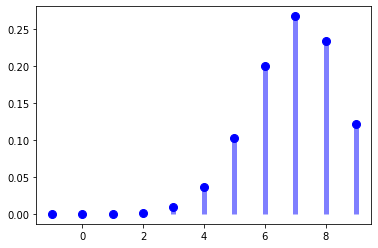

In [3]:
L = 10
fig, ax = plt.subplots(1, 1);
x = np.arange(binom.ppf(0.00, L, p),binom.ppf(0.99, L, p));
ax.plot(x, binom.pmf(x, L, p), 'bo', ms=8, label='binom pmf');
ax.vlines(x, 0, binom.pmf(x, L, p), colors='b', lw=5, alpha=0.5);

2) Mettez en œuvre le Bagging avec des arbres de régression de profondeur 1 (en Anglais stumps), puis avec des arbres plus profonds, en partant du code ci-dessous. On pourra utiliser BaggingRegressor.

In [4]:
# création d'un jeu de données aléatoires
def gendata(noise_level=0.5, seed=1):
    rng = np.random.RandomState(seed)
    X = np.sort(5 *rng.rand(80, 1), axis=0) 
    y = np.sin(X).ravel() 
    y[::5] += 1 *(noise_level -rng.rand(16)) 
    return X, y
    
X, y = gendata(0.5,1)
X_test = np.arange(0.0, 5.0, 0.01)[:, np.newaxis]

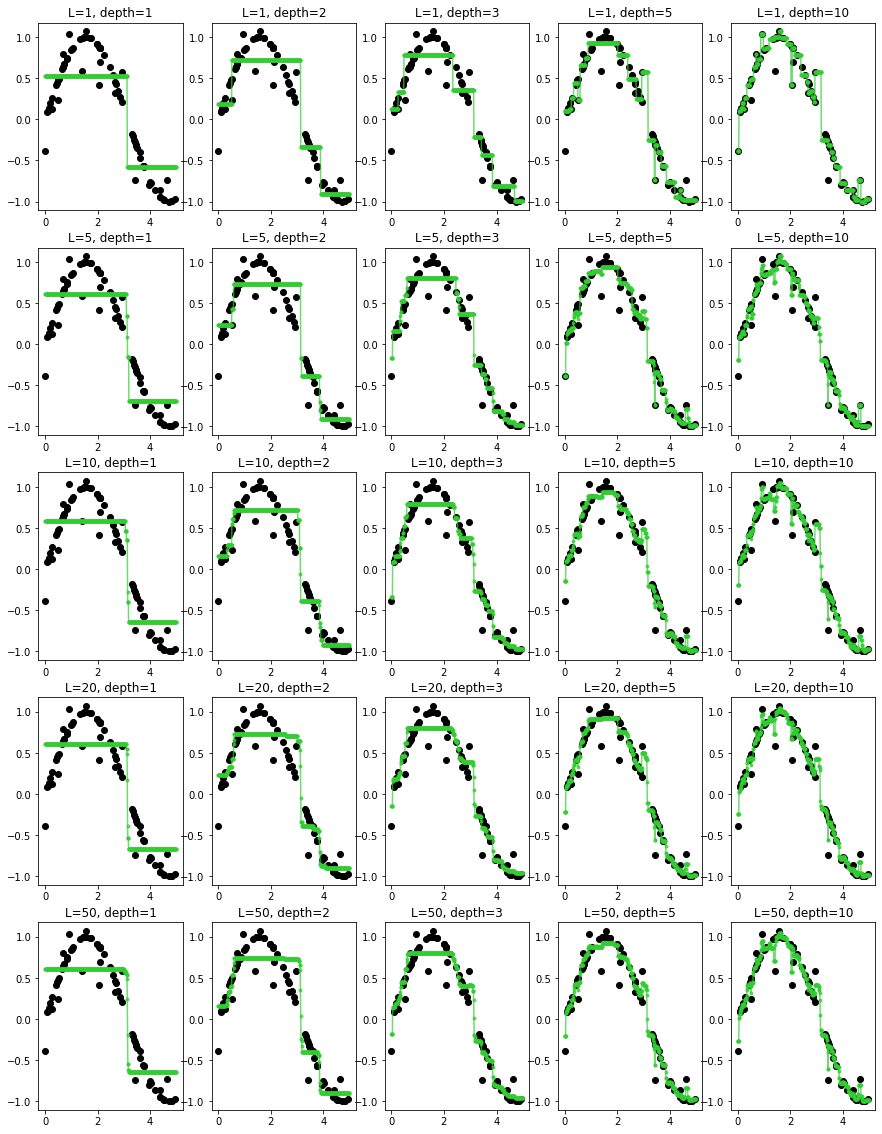

In [5]:
# valeurs pour L et profondeur
sample_size = len(y)
L_vals = [1, 5, 10, 20, 50]
depth_vals = [1, 2, 3, 5, 10]
# initialisation de la figure
plt.figure
fig, axs = plt.subplots(len(L_vals), len(depth_vals), facecolor='w', edgecolor='k', figsize=(15,20))
# boucle sur L et profondeur
for index_L, L in enumerate(L_vals):
    for index_depth, depth in enumerate(depth_vals):
        # estimation en bagging
        bagging = BaggingRegressor(base_estimator=DecisionTreeRegressor(max_depth=depth), n_estimators = L)
        bagging.fit(X, y)
        # predictions sur echa tillon test
        y_test = bagging.predict(X_test)
        # traçage des graphs
        axs[index_L][index_depth].plot(X, y, 'o', c="k", label="data")
        axs[index_L][index_depth].plot(X_test, y_test, marker='.', color='limegreen', alpha=0.7, linewidth = 1.5)
        axs[index_L][index_depth].set_title("L=" + str(L) + ", depth=" + str(depth))


3) Illustrer graphiquement le rôle de L ainsi que de la profondeur des arbres (max_depth) en jouant sur ces deux paramètres.

On tire deux conclusions. D'abord, la profondeur semble jouer un rôle prépondérant dans la performance du modèle en bagging. Une faible profondeur (par exemple: 1 ou 2) ne semble pas parvenir à restituer la variation des données. On est en under-fitting, et les performances en prédiction sont insatisfaisantes. A l'inverse, une profondeur de 10 semble donner des résultats nettement plus proches des données, avec possiblement même un risque d'over-fitting. La seconde conclusion est que L semble jouer un rôle faible. Entre L=1 et L=50,, aucune différence notable de performance ne peut être observée, quel que soit la profondeur choisie.

4) A quoi reconnaît-on que les estimateurs construits par les arbres sont biaisés et que le bagging réduit leur variance ?

On peut observer le biais en considérant la différence systématique qui existe entre les données observées et les prédictions formées par les arbres. Comme on peut l'observer, surtout à faible profondeur, les prédictions formées peuvent différer significativement des observations. Le bagging réduit la variance en combinant différent estimateurs. On peut observer par exemple qu'à grande profondeur d'arbres (n=10) et faible valeur de L (L=1), on overfit et l'arbre capture le bruit des données (il colle aux outliers). Cela résulte en une varaince accrue à la prédiction. A l'inverse, en augmentant L (L=50), l'estimateur bagging capture l'essentiel des variations mais tend à moins overfitter, en allant moins sytématiquement coller aux valeurs de bruit: le bagging a réduit la variance.

5) En jouant sur le niveau de bruit mettez en évidence le sur-apprentissage.

On va ici générer des prédictions en bagging sur des arbres de profondeur depth=20. Avec une profondeur aussi importante, on s'attend à observer de l'overfitting, même avec du bagging. Pour observer ce phénomène, on créer des sets de données avec un bruit de plus en plus important, et on observe si les prédictions en bagging capturent ce bruit, totalement ou en partie, au lieu de coller au processus sous-jacent.

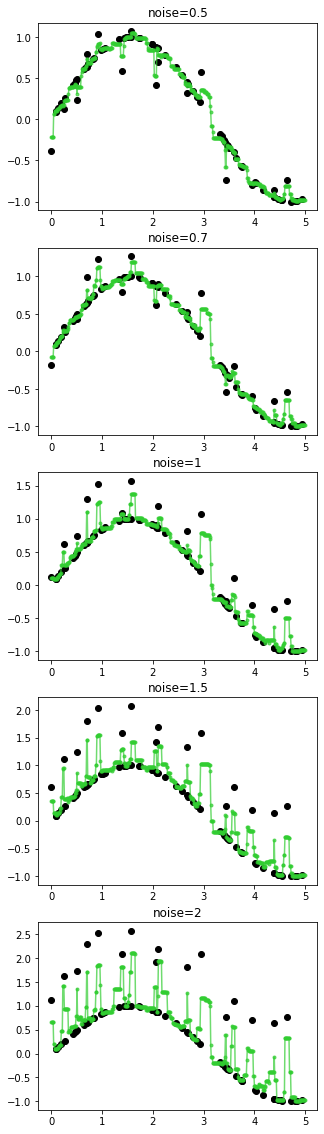

In [6]:
# niveaux de bruit
noise_vals = [0.5, 0.7, 1, 1.5, 2]
# initialisation de la figure
plt.figure
fig, axs = plt.subplots(len(noise_vals), facecolor='w', edgecolor='k', figsize=(5,20))
# boucle sur le niveau de bruit
for index_noise, noise in enumerate(noise_vals):
    # génération de données bruitées
    X_noise, y_noise = gendata(noise,1)
    # estimation en bagging
    bagging = BaggingRegressor(base_estimator=DecisionTreeRegressor(max_depth=50), n_estimators = 20)
    bagging.fit(X_noise, y_noise)
    # predictions sur echantillon test
    y_test = bagging.predict(X_test)
    # traçage des graphs
    axs[index_noise].plot(X_noise, y_noise, 'o', c="k")
    axs[index_noise].plot(X_test, y_test, marker='.', color='limegreen', alpha=0.7, linewidth = 1.5)
    axs[index_noise].set_title("noise=" + str(noise))

On observe bien un phénomène d'overfitting. On voit bien que le modèle va systématiquement capturer le bruit généré, et ce de manière de plus en plus importante à mesure que le niveau de bruit augmente.

6) Observer qu’on peut réduire ce phénomène en sous-échantillonnant aléatoirement (sans remise) au lieu de prendre des échantillons bootstrap.

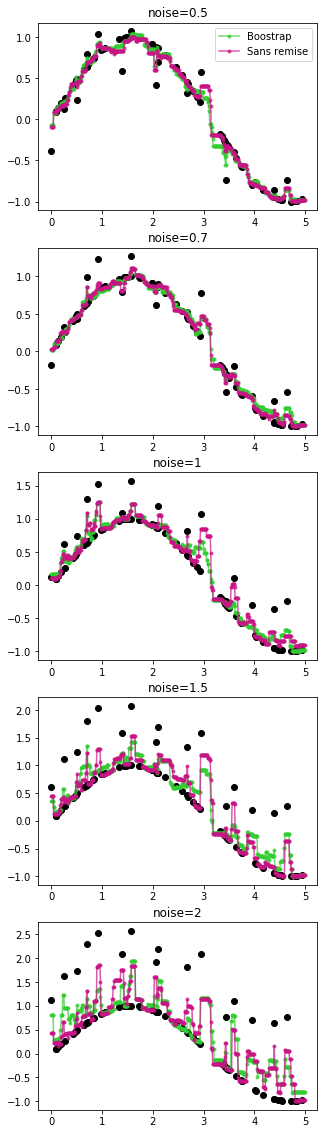

In [7]:
# on réitère l'exercice en faisant varier le bagging en mode bootstrap ou sans remplacement
# niveaux de bruit
noise_vals = [0.5, 0.7, 1, 1.5, 2]
# initialisation de la figure
plt.figure
fig, axs = plt.subplots(len(noise_vals), facecolor='w', edgecolor='k', figsize=(5,20))
# boucle sur le niveau de bruit
for index_noise, noise in enumerate(noise_vals):
    # génération de données bruitées
    X_noise, y_noise = gendata(noise,1)
    # estimation en bagging avec bootstrap (option par défaut)
    bagging = BaggingRegressor(base_estimator=DecisionTreeRegressor(max_depth=10), n_estimators = 10,
                               max_samples = 0.5, bootstrap=True)
    bagging.fit(X_noise, y_noise)
    # predictions sur echantillon test
    y_test = bagging.predict(X_test)
    # estimation en bagging sans remise
    bagging = BaggingRegressor(base_estimator=DecisionTreeRegressor(max_depth=10), n_estimators = 10,
                               max_samples = 0.5, bootstrap=False)
    bagging.fit(X_noise, y_noise)
    # predictions sur echantillon test
    y_test_sr = bagging.predict(X_test)
    # traçage des graphs
    axs[index_noise].plot(X_noise, y_noise, 'o', c="k")
    axs[index_noise].plot(X_test, y_test, marker='.', color='limegreen', alpha=0.7, linewidth = 1.5, label="Boostrap")
    axs[index_noise].plot(X_test, y_test_sr, marker='.', color='mediumvioletred', alpha=0.7, linewidth = 1.5, label="Sans remise")
    axs[index_noise].set_title("noise=" + str(noise))
    
axs[0].legend()
plt.show()

On observe effectivement une légère baisse de l'overfitting lorsqu'on procède à un tirage sans remise, mais le gain n'est pas spectaculaire.

## Random Forests

7) Évaluez le score par 7-fold cross-validation des Random Forests sur les datasets boston, diabetes, iris et digits. Comparez ces performances avec celles d’un SVM linéaire.

In [8]:
# import des datasets
# Boston
boston = datasets.load_boston()
X_boston = boston.data
X_boston = preprocessing.scale(X_boston)
y_boston = boston.target
# diabetes
diabetes = datasets.load_diabetes()
X_diabetes = diabetes.data
X_diabetes = preprocessing.scale(X_diabetes)
y_diabetes = diabetes.target
# iris
iris = datasets.load_iris()
X_iris = iris.data
X_iris = preprocessing.scale(X_iris)
y_iris = iris.target
# digits
digits = datasets.load_digits()
X_digits = digits.data 
X_digits = preprocessing.scale(X_digits)
y_digits = digits.target

In [9]:
# déclaration des classes
rfc = RandomForestClassifier()
rfr = RandomForestRegressor()
svc = LinearSVC()
svr = SVR()
# évaluation du score par validation croisée: Boston
print("Le score pour le dataset Boston avec random forest est:" + str(round(np.mean(cross_val_score(rfr, X_boston, y_boston, cv=7)),3)))
print("Le score pour le dataset Boston avec SVR est:" + str(round(np.mean(cross_val_score(svr, X_boston, y_boston, cv=7)),3)))
print()
# évaluation du score par validation croisée: diabetes
print("Le score pour le dataset diabetes avec random forest est:" + str(round(np.mean(cross_val_score(rfr, X_diabetes, y_diabetes, cv=7)),3)))
print("Le score pour le dataset diabetes avec SVR est:" + str(round(np.mean(cross_val_score(svr, X_diabetes, y_diabetes, cv=7)),3)))
print()
# évaluation du score par validation croisée: iris
print("Le score pour le dataset iris avec random forest est:" + str(round(np.mean(cross_val_score(rfc, X_iris, y_iris, cv=7)),3)))
print("Le score pour le dataset iris avec SVC est:" + str(round(np.mean(cross_val_score(svc, X_iris, y_iris, cv=7)),3)))
print()
# évaluation du score par validation croisée: digits
print("Le score pour le dataset digits avec random forest est:" + str(round(np.mean(cross_val_score(rfc, X_digits, y_digits, cv=7)),3)))
print("Le score pour le dataset digits avec SVC est:" + str(round(np.mean(cross_val_score(svc, X_digits, y_digits, cv=7)),3)))

Le score pour le dataset Boston avec random forest est:0.631
Le score pour le dataset Boston avec SVR est:0.464

Le score pour le dataset diabetes avec random forest est:0.365
Le score pour le dataset diabetes avec SVR est:0.15

Le score pour le dataset iris avec random forest est:0.953
Le score pour le dataset iris avec SVC est:0.927

Le score pour le dataset digits avec random forest est:0.901
Le score pour le dataset digits avec SVC est:0.911


Globalement, on remarque que les random forest ont tendance à produire de meilleures prédictions que les modèles à support vector. Cel ne se vérifie pas pour le dernier dataset, pour lequel le SVC réalise une performance marginalement meilleure que la random forest.

8) En utilisant le dataset iris restreint aux deux premières variables explicatives afficher la probabilité de prédiction des classes.

In [10]:
# on ne garde que les deux premiers features du dataset iris
X_iris = X_iris[:,:2]
X_iris
# on fit une random forest
rfc.fit(X_iris, y_iris);
# probabilité de prédiction des classes
class_probabilities = rfc.predict_proba(X_iris)

In [11]:
print("Les probabilités de prédiction des classes sont données par:")
print()
print(class_probabilities)

Les probabilités de prédiction des classes sont données par:

[[1.         0.         0.        ]
 [1.         0.         0.        ]
 [1.         0.         0.        ]
 [1.         0.         0.        ]
 [1.         0.         0.        ]
 [1.         0.         0.        ]
 [1.         0.         0.        ]
 [1.         0.         0.        ]
 [1.         0.         0.        ]
 [1.         0.         0.        ]
 [1.         0.         0.        ]
 [1.         0.         0.        ]
 [1.         0.         0.        ]
 [1.         0.         0.        ]
 [0.9        0.1        0.        ]
 [1.         0.         0.        ]
 [1.         0.         0.        ]
 [1.         0.         0.        ]
 [0.9        0.1        0.        ]
 [1.         0.         0.        ]
 [1.         0.         0.        ]
 [1.         0.         0.        ]
 [1.         0.         0.        ]
 [0.8        0.1        0.1       ]
 [1.         0.         0.        ]
 [1.         0.         0.        ]
 [

9) Comparez les scores par 6-fold cross-validation des Random Forests et des arbres de décisions pures (obtenus avec DecisionTreeClassifier), sur le dataset digits. On fera varier le paramètre max_depth entre 1 et 15. Mettre en évidence le fait que les Random Forests permettent de réduire le sur-apprentissage, et ce même pour des arbres profonds.

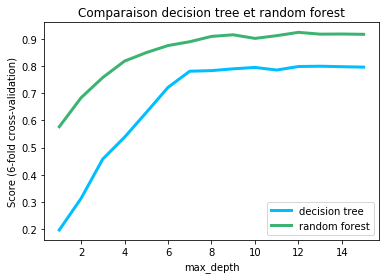

In [12]:
max_depth = 15
depths = np.arange(0, max_depth, 1)
scores_decision_tree = np.zeros(max_depth)
scores_random_forest = np.zeros(max_depth)
# boucle sur les profondeurs
for depth in depths:
    # decision tree
    dt = DecisionTreeClassifier(max_depth = depth + 1)
    dt.fit(X_digits,y_digits)
    scores_decision_tree[depth] = np.mean(cross_val_score(dt,X_digits,y_digits,cv=6))
    # random forest
    rfc = RandomForestClassifier(max_depth = depth + 1)
    rfc.fit(X_digits,y_digits)
    scores_random_forest[depth] = np.mean(cross_val_score(rfc,X_digits,y_digits,cv=6))

# graphique
plt.figure
plt.plot(depths+1, scores_decision_tree, linewidth=3, color='deepskyblue', label="decision tree")
plt.plot(depths+1, scores_random_forest, linewidth=3, color='mediumseagreen', label="random forest")
plt.title('Comparaison decision tree et random forest')
plt.ylabel('Score (6-fold cross-validation)')
plt.xlabel('max_depth')
plt.legend()
plt.show()

On remarque que les random forest obtiennent de meilleurs résultats en test que les decision tree. Le fait qu'elles atteignent une meilleure performance sur des niveaux de profondeur élevés implique qu'lles limitent l'overfitting.

## Boosting

10) Démontrez la propriété...

À partir des propriétés de l'espérance conditionnelle, décomposons l'expression $\mathbb{E}[e^{-Yf(x)}]$ de la manière suivante :

$\mathbb{E}[e^{-Yf(x)}] = P(Y=-1|x)e^{+f(x)} + P(Y=-1|x)e^{-f(x)}$ 

$\mathbb{E}[e^{-Yf(x)}] = (1 - \eta (x))e^{+f(x)} + \eta (x) e^{-f(x)}$

On dérive l'expression par rapport à $f(x)$.

$\frac{\partial \mathbb{E}[exp(-Yf(x))]}{\partial f(x)} = (1 - \eta (x))e^{+f(x)} - \eta (x) e^{-f(x)}$

en particulier, en $f^*(x)$ : $(1 - \eta (x))e^{+f^*(x)} - \eta (x) e^{-f^*(x)} = 0$

$(1 - \eta (x)) e^{2f^*(x)} - \eta (x) = 0$

Finalement, $f^*(x) = \dfrac{1}{2}log(\dfrac{\eta (x)}{1 - \eta (x)})$

11) En déduire que le classifieur de Bayes ...

On a : $h^*_{\phi_0} = sign(2\eta - 1)$

En utilisant le résultat obtenu lors de la question précédente, on a :
$h^*_{exp} = sign(f_{exp})$, où $f_{exp}(x) = \dfrac{1}{2}log(\dfrac{\eta (x)}{1 - \eta (x)})$

$h^*_{exp} = sign(\dfrac{1}{2}log(\dfrac{\eta (x)}{1 - \eta (x)})) = sign(log(\dfrac{\eta (x)}{1 - \eta (x)})) $

Or 

$$
log(\dfrac{\eta (x)}{1 - \eta (x)}) \left\{
    \begin{array}{ll}
        \geq 0 & \mbox{si } \eta (x) \geq 1 - \eta (x) \\
        < 0 & \mbox{sinon.}
    \end{array}
\right.
$$

Donc

$$
log(\dfrac{\eta (x)}{1 - \eta (x)}) \left\{
    \begin{array}{ll}
        \geq 0 & \mbox{si } 2\eta (x) \geq 1 \\
        < 0 & \mbox{sinon.}
    \end{array}
\right.
$$

D'où $h^*_{exp} = sign(2\eta - 1) = h^*_{\phi_0}$

## Adaboost

12) Montrer que la solution du dernier programme d’optimisation...

En utilisant un raisonnement analogue à la question 9, on obtient : 

$\mathbb{E}_{\omega^{m-1}}[e^{-cY\hat{h}_{m}(x)}] = P_{\omega^{m-1}}(Y=\hat{h}_{m}(x))e^{-c} + P_{\omega^{m-1}}(Y=\hat{h}_{m}(x))e^{c}$ 

On dérive par rapport à $c$ : 
$\frac{\partial \mathbb{E}_{\omega^{m-1}}[e^{-cY\hat{h}_{m}(x)}]}{\partial c} = -P_{\omega^{m-1}}(Y=\hat{h}_{m}(x))e^{-c} + P_{\omega^{m-1}}(Y\neq \hat{h}_{m}(x))e^{c}$

En particulier, en $c^*$ : 

$-P_{\omega^{m-1}}(Y=\hat{h}_{m}(x))e^{-c^*} + P_{\omega^{m-1}}(Y\neq\hat{h}_{m}(x))e^{c^*} = 0$

D'où le résultat : $c^* = \dfrac{1}{2}log(\dfrac{P_{\omega^{m-1}}(Y=\hat{h}_{m}(x))}{P_{\omega^{m-1}}(Y\neq\hat{h}_{m}(x))})$

13) Montrer que les poids...

14) Mettre en œuvre AdaBoost avec des arbres de profondeur 1, puis 2, puis 10, sur le jeu de données digits. On calculera notamment la précision obtenue par 6-fold cross-validation.

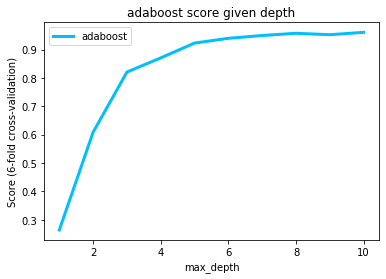

In [13]:
max_depth = 10
depths = np.arange(0, max_depth, 1)
scores_adaboost = np.zeros(max_depth)
# boucle sur les profondeurs
for depth in depths:
    # adaboost score
    dtc = DecisionTreeClassifier(max_depth=depth+1)
    clf = AdaBoostClassifier(base_estimator=dtc, n_estimators=100, random_state=0)
    scores_adaboost[depth] = np.mean(cross_val_score(clf, X_digits, y_digits, cv=6))
    
# graphique
plt.figure
plt.plot(depths+1, scores_adaboost, linewidth=3, color='deepskyblue', label="adaboost")
plt.title('adaboost score given depth')
plt.ylabel('Score (6-fold cross-validation)')
plt.xlabel('max_depth')
plt.legend()
plt.show()

Avec une profondeur suffisante (ici 8 ou plus), on remarque que l'algorithm converge vers un score très élevé excédant 0.9.

15) Appliquer AdaBoost sur les données digits découpées en deux échantillons : apprentissage (75%) et test (25%). Tracer les erreurs (0/1) d’apprentissage et de test en fonction du nombre d’itérations.

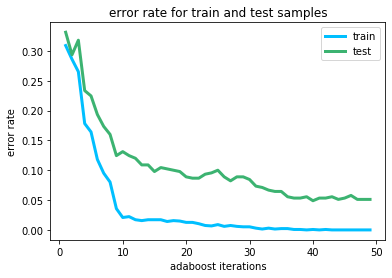

In [14]:
# création des échantillons train et test
X_digits_train, X_digits_test, y_digits_train, y_digits_test = train_test_split(digits.data, digits.target,
                                                                                test_size=0.25, random_state=1)
max_iter = 50
iterations = np.arange(1, max_iter, 1)
scores_adaboost_train = np.zeros(len(iterations))
scores_adaboost_test = np.zeros(len(iterations))
dtc = DecisionTreeClassifier(max_depth=5)

# boucle sur les iterations
for index,iter in enumerate(iterations):
    # adaboost score
    clf = AdaBoostClassifier(base_estimator=dtc, n_estimators=iter, random_state=0)
    clf.fit(X_digits_train, y_digits_train)
    scores_adaboost_train[index] = clf.score(X_digits_train, y_digits_train)
    scores_adaboost_test[index] = clf.score(X_digits_test, y_digits_test)

# graphique
plt.figure
plt.plot(iterations, 1 - scores_adaboost_train, linewidth=3, color='deepskyblue', label="train")
plt.plot(iterations, 1 - scores_adaboost_test, linewidth=3, color='mediumseagreen', label="test")
plt.title('error rate for train and test samples')
plt.ylabel('error rate')
plt.xlabel('adaboost iterations')
plt.legend()
plt.show()

On se rend compte que même avec un classificateur faible, on obtient après l'utilisation d'adaboost un classifieur très performant, qui réduit le taux d'erreur à près de 0.

16) Que remarquez vous ? Que se passe-t-il si la profondeur des arbres de classification est grande ?

On réitère l'exercice avec une profondeur d'arbre beaucoup plus grande (50):

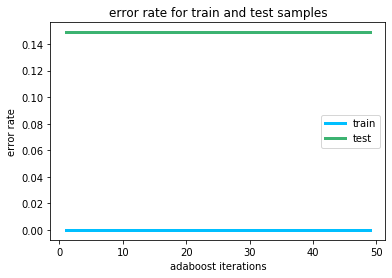

In [15]:
max_iter = 50
iterations = np.arange(1, max_iter, 1)
scores_adaboost_train = np.zeros(len(iterations))
scores_adaboost_test = np.zeros(len(iterations))
dtc = DecisionTreeClassifier(max_depth=15)

# boucle sur les iterations
for index,iter in enumerate(iterations):
    # adaboost score
    clf = AdaBoostClassifier(base_estimator=dtc, n_estimators=iter, random_state=0)
    clf.fit(X_digits_train, y_digits_train)
    scores_adaboost_train[index] = clf.score(X_digits_train, y_digits_train)
    scores_adaboost_test[index] = clf.score(X_digits_test, y_digits_test)

# graphique
plt.figure
plt.plot(iterations, 1 - scores_adaboost_train, linewidth=3, color='deepskyblue', label="train")
plt.plot(iterations, 1 - scores_adaboost_test, linewidth=3, color='mediumseagreen', label="test")
plt.title('error rate for train and test samples')
plt.ylabel('error rate')
plt.xlabel('adaboost iterations')
plt.legend()
plt.show()


Si la profondeur de l'arbre est trop grande, l'agorithme ne fonctionnera pas bien. Comme les données sont classées parfaitement sur l'échantillon train, l'algorithme adaboost s'arrête, et le modèle obtenu souffre d'overfitting. De ce fait, ses performances sur l'échantillon test sont médiocres, alors même qu'elles sont parfaites sur l'échantillon train.